# Seattle Airbnb dataset scraped on the 25th of October 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import re
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [15, 9]
plt.rcParams['figure.dpi'] = 100 

In [3]:
# import sys
# !{sys.executable} -m pip install unidecode

In [254]:
listing_df = pd.read_csv('../data/seattle_listings.csv.gz') 
#calendar_df = pd.read_csv('../data/seatlle_calendar.csv.gz.csv') 
#reviews_df = pd.read_csv('../data/seattle_reviews.csv.gz') 

### User defined functions

In [255]:
def convert_to_binary(df, col):
    '''Converts binary values t and f into 1 and 0 values and nan values into 0.'''
    df[col] = df[col].replace({"t": 1, "f": 0, "nan": "NaN"}).fillna(0)
    return df[col]

In [256]:
def create_dummy_cols(df, cat_cols, dummy_na):
    '''Creates dummy variables from categorical variables'''
    for col in cat_cols:
        try:
            dummy_df = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)
            df=pd.concat([df.drop(col, axis=1), dummy_df], axis=1)
        except:
            continue
    return df

In [257]:
#Remove special characters from numeric columns and convert the data type in to a float
def remove_special_char(df, col):
    '''Remove special characters such as % and $ from numeric variables and converts them into float'''
    df[col] = df[col].replace(regex = True, to_replace = r'[^0-9.\-]', value=r'')
    df[col] = df[col].astype("float")
    return df[col]

### Data Cleaning 

We remove all the columns that 
- has the same constant value for the entire dataset 
- are completely missing
- contains URLs (as we are not going to do any text analytics at this analysis)

In [258]:
remove_list = listing_df.columns[(listing_df.nunique()<=1) 
                                 | (listing_df.columns.str.contains('url'))
                                 | (listing_df.isnull().mean()==1)
                                ].tolist()

In [259]:
remove_list.remove('last_scraped')

In [260]:
remove_list

['listing_url',
 'scrape_id',
 'picture_url',
 'host_url',
 'host_thumbnail_url',
 'host_picture_url',
 'bathrooms',
 'calendar_updated',
 'has_availability',
 'calendar_last_scraped']

In [261]:
listing_df = listing_df.drop((listing_df.columns[listing_df.isnull().mean()==1]).union(remove_list),axis=1)

In [262]:
listing_df.shape

(4335, 64)

In [263]:
listing_df.iloc[:, :20].head()

,id,last_scraped,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified
0,2318,2020-10-25,Casa Madrona - Urban Oasis 1 block from the park!,"Gorgeous, architect remodeled, Dutch Colonial ...",Madrona is a hidden gem of a neighborhood. It ...,2536,Megan,2008-08-26,"Seattle, Washington, United States",I welcome guests from all walks of life and ev...,within a day,100%,78%,t,Minor,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t
1,9419,2020-10-25,Glorious sun room w/ memory foambed,"Keeping you safe is our priority, we are adher...","Lots of restaurants (see our guide book) bars,...",30559,Angielena,2009-08-09,"Seattle, Washington, United States",I am a visual artist who is the director of ...,within a few hours,100%,89%,t,Georgetown,8.0,8.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t
2,9531,2020-10-25,The Adorable Sweet Orange Craftsman,The Sweet Orange is a delightful and spacious ...,The neighborhood is awesome! Just far enough ...,31481,Cassie,2009-08-13,"Seattle, Washington, United States",The Sweet Orange reflects my passion and zest ...,within a day,100%,64%,t,The Junction,2.0,2.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t
3,9534,2020-10-25,The Coolest Tangerine Dream MIL!,Welcome to my delicious Tangerine Dream! A co...,The neighborhood is the best of two worlds...w...,31481,Cassie,2009-08-13,"Seattle, Washington, United States",The Sweet Orange reflects my passion and zest ...,within a day,100%,64%,t,The Junction,2.0,2.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t
4,9596,2020-10-25,"the down home , spacious, central and fab!","We are in a great neighborhood, quiet, full of...","if you arrive early for check in at 3, I reco...",14942,Joyce,2009-04-26,"Seattle, Washington, United States",I am a therapist/innkeeper.I know my city well...,within a few hours,90%,94%,f,Wallingford,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t


In [264]:
listing_df.iloc[:, 21:40].head()

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm
0,Madrona,Central Area,47.61082,-122.29082,Entire house,Entire home/apt,9,2.5 baths,4.0,4.0,"[""Children\u2019s books and toys"", ""Iron"", ""Ha...",$295.00,1,1125,1,2,1125,1125,1.0
1,Georgetown,Other neighborhoods,47.55017,-122.31937,Private room in apartment,Private room,2,3 shared baths,1.0,2.0,"[""Iron"", ""Hangers"", ""Lock on bedroom door"", ""H...",$55.00,2,180,2,2,180,180,2.0
2,Fairmount Park,West Seattle,47.55539,-122.38474,Entire house,Entire home/apt,4,1 bath,2.0,3.0,"[""Iron"", ""TV"", ""Hangers"", ""Cable TV"", ""Private...",$155.00,28,1125,28,28,1125,1125,28.0
3,Fairmount Park,West Seattle,47.55624,-122.38598,Entire guest suite,Entire home/apt,3,1 bath,2.0,2.0,"[""Conditioner"", ""Iron"", ""TV"", ""Hangers"", ""Cabl...",$125.00,5,1125,5,5,1125,1125,5.0
4,Wallingford,Other neighborhoods,47.65479,-122.33652,Entire apartment,Entire home/apt,4,1 bath,1.0,4.0,"[""Iron"", ""TV"", ""Hangers"", ""Cable TV"", ""Hair dr...",$100.00,4,60,4,4,1125,1125,4.0


In [265]:
listing_df.iloc[:, 41:60].head()

,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count
0,0,0,26,26,32,4,0,2008-09-15,2020-02-01,100.0,10.0,10.0,10.0,10.0,10.0,10.0,STR-OPLI-19-002837,f,2
1,29,59,89,364,148,2,0,2010-07-30,2019-12-27,93.0,10.0,10.0,10.0,10.0,10.0,10.0,str-opli-19-003039,f,8
2,0,0,19,294,40,1,0,2012-01-12,2019-12-30,100.0,10.0,10.0,10.0,10.0,10.0,10.0,STR-OPLI-19-002182,f,2
3,10,14,40,315,53,8,0,2012-01-15,2020-08-31,100.0,10.0,10.0,10.0,10.0,10.0,10.0,STR-OPLI-19-002182,f,2
4,0,0,6,6,97,4,1,2011-06-15,2020-09-28,91.0,9.0,9.0,10.0,9.0,10.0,9.0,STR-OPLI-19-002622,f,2


In [266]:
listing_df.iloc[:, 60:74].head()

,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2,0,0,0.22
1,0,8,0,1.19
2,2,0,0,0.37
3,2,0,0,0.50
4,2,0,0,0.85


### Date Columns

Convert all date related columns into date types.

In [267]:
date_col_list = ['last_scraped','host_since', 'first_review', 'last_review']

In [268]:
listing_df[date_col_list]=listing_df[date_col_list].apply(pd.to_datetime, errors='coerce')

In [269]:
listing_df[date_col_list].describe(datetime_is_numeric=True)

,last_scraped,host_since,first_review,last_review
count,4335,4327,3508,3508
mean,2020-10-25 00:00:00,2015-10-24 23:01:05.726831360,2017-10-30 19:27:50.695553024,2020-05-12 19:00:45.153933824
min,2020-10-25 00:00:00,2008-08-26 00:00:00,2008-09-15 00:00:00,2012-06-06 00:00:00
25%,2020-10-25 00:00:00,2013-09-25 00:00:00,2016-06-22 18:00:00,2020-02-28 00:00:00
50%,2020-10-25 00:00:00,2015-08-26 00:00:00,2018-03-25 00:00:00,2020-09-07 00:00:00
75%,2020-10-25 00:00:00,2017-07-24 00:00:00,2019-07-12 06:00:00,2020-10-09 00:00:00
max,2020-10-25 00:00:00,2020-10-23 00:00:00,2020-10-24 00:00:00,2020-10-24 00:00:00


### Binary Columns

We convert all the boolean columns into binary floats to use them in a more meaningful way when building a model later on.

In [270]:
bool_list = ["instant_bookable", "host_is_superhost", "host_identity_verified",'host_has_profile_pic']
listing_df[bool_list] = listing_df[bool_list].apply(lambda x: convert_to_binary(x, bool_list), axis = 1)

### Numeric Columns

We create a feature that tells us the number of days the host listed her/his property. The data was scraped on the 2020-10-25, so we will calculate the number of days host listed her/his property until the date this data was scraped. Similarly, we create a column stating the number of days since the listing last reviewed.

In [271]:
listing_df["days_since_host"] =  (listing_df['last_scraped'] - listing_df['host_since']).dt.days
listing_df["days_since_last_review"] =  (listing_df['last_scraped'] - listing_df['last_review']).dt.days
listing_df["days_since_first_review"] =  (listing_df['last_scraped'] - listing_df['first_review']).dt.days

In [272]:
listing_df[["days_since_host","days_since_last_review", "days_since_first_review"]].head()

,days_since_host,days_since_last_review,days_since_first_review
0,4443.0,267.0,4423.0
1,4095.0,303.0,3740.0
2,4091.0,300.0,3209.0
3,4091.0,55.0,3206.0
4,4200.0,27.0,3420.0


We remove special characters from numeric columns such as % or texts:

In [273]:
col_list = ["price", "host_response_rate", "host_acceptance_rate"]
listing_df[col_list] = listing_df[col_list].apply(lambda x: remove_special_char(x, col_list), axis = 1)

In [274]:
listing_df[["price", "host_response_rate", "host_acceptance_rate"]].head()

,price,host_response_rate,host_acceptance_rate
0,295.0,100.0,78.0
1,55.0,100.0,89.0
2,155.0,100.0,64.0
3,125.0,100.0,64.0
4,100.0,90.0,94.0


In [275]:
listing_df.bathrooms_text.unique()

array(['2.5 baths', '3 shared baths', '1 bath', '2 shared baths',
       '2 baths', '1 private bath', '1.5 baths', '4 shared baths',
       '1 shared bath', '3 baths', '0 baths', '1.5 shared baths',
       '4.5 baths', nan, '3.5 baths', 'Half-bath', '5 shared baths',
       '2.5 shared baths', '4 baths', '3.5 shared baths',
       '0 shared baths', '6 baths', 'Shared half-bath',
       'Private half-bath'], dtype=object)

In [285]:
listing_df.n_bathrooms.unique()

array(['2.5', '3', '1', '2', '1.5', '4', '0', '4.5', 0, '3.5', '0.5', '5',
       '6'], dtype=object)

Create a new variable that indicates whether a bath is private or shared named as private_bath_yn and takes the value 1 if it is private, 0 if shared.

In [278]:
# if it contains private then 1 shared 0 - private_bath_yn
listing_df['private_bath_yn'] = np.where(listing_df.bathrooms_text.str.contains('private'), 1, 0)

- Replace the values contain '-bath' (only those which are half bath) with 0.5 
- Remove all non-digit characters 
- Fill empty values with 0
- Assign it to a new variable called 'n_bathrooms'

In [279]:
listing_df['n_bathrooms'] = listing_df.bathrooms_text.str.replace(r'(^.*-bath.*$)', '0.5', regex=True)
listing_df['n_bathrooms'] = listing_df.n_bathrooms.str.replace("[^\d\.]", "", regex = True).fillna(0)

In [286]:
listing_df[['private_bath_yn', 'bathrooms_text', 'n_bathrooms']].head(10)

,private_bath_yn,bathrooms_text,n_bathrooms
0,0,2.5 baths,2.5
1,0,3 shared baths,3
2,0,1 bath,1
3,0,1 bath,1
4,0,1 bath,1
5,0,1 bath,1
6,0,2 shared baths,2
7,0,2 baths,2
8,0,2 shared baths,2
9,0,1 bath,1


## Categorical Columns

In [290]:
listing_df["host_response_time"].unique()

array(['within a day', 'within a few hours', 'within an hour', nan,
       'a few days or more'], dtype=object)

Replace the empty space with underscore '_' so we can create a dummy variable for _host_response_time_ column.

In [295]:
listing_df["host_response_time"] = listing_df["host_response_time"].str.replace(' ', '_').fillna('not_responded')

In [300]:
listing_df["neighbourhood_cleansed"].unique()

array(['Madrona', 'Georgetown', 'Fairmount Park', 'Wallingford',
       'High Point', 'Belltown', 'Whittier Heights', 'Loyal Heights',
       'Mid-Beacon Hill', 'Windermere', 'Seward Park', 'Alki',
       'North Admiral', 'Fremont', 'Green Lake', 'Harrison/Denny-Blaine',
       'Portage Bay', 'Phinney Ridge', 'Crown Hill', 'Columbia City',
       'Lawton Park', 'North Queen Anne', 'West Queen Anne', 'First Hill',
       'Stevens', 'Eastlake', 'Broadway', 'Arbor Heights', 'Greenwood',
       'North Beacon Hill', 'Wedgwood', 'Cedar Park', 'Pike-Market',
       'Lower Queen Anne', 'Mount Baker', 'Mann', 'Genesee',
       'Central Business District', 'Fauntleroy', 'Ravenna', 'Bryant',
       'University District', 'South Delridge', 'Atlantic', 'Broadview',
       'Adams', 'Maple Leaf', 'East Queen Anne', 'Pioneer Square',
       'Highland Park', 'West Woodland', 'Montlake', 'Haller Lake',
       'Madison Park', 'Leschi', 'Matthews Beach', 'Minor', 'Sunset Hill',
       'North Beach/Blue Ri

In [301]:
listing_df["host_neighbourhood"].unique()

array(['Minor', 'Georgetown', 'The Junction', 'Wallingford', 'High Point',
       'Belltown', 'Ballard', 'North Beacon Hill', 'Windermere',
       'Columbia City', 'North Admiral', 'Fremont', 'Alki', 'Green Lake',
       'Seward Park', 'Harrison/Denny-Blaine', 'Portage Bay',
       'Phinney Ridge', 'Crown Hill', 'Magnolia', 'Queen Anne',
       'First Hill', 'Stevens', 'Eastlake', 'Capitol Hill',
       'Arbor Heights', 'Greenwood', 'Wedgewood', 'Cedar Park',
       'Pike Place Market', 'Lower Queen Anne', 'Mount Baker',
       'Central Business District', 'Fauntleroy', 'Bryant',
       'South Delridge', 'Atlantic', 'Broadview', 'Maple Leaf',
       'Pioneer Square', 'Ravenna', 'Highland Park',
       'University District', 'Montlake', 'Haller Lake', 'Madison Park',
       'Roosevelt', 'Madrona', 'Mathews Beach', nan, 'Leschi',
       'Victory Heights', 'Brighton', 'View Ridge', 'North Delridge',
       'Seaview', 'Kihei/Wailea', 'Yesler Terrace', 'Holly Park',
       'Bitter Lake', 'W

In [302]:
# TODO: create a dummy variable with the host verification
listing_df.host_verifications.unique()

array(["['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']",
       "['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'government_id']",
       "['email', 'phone', 'reviews', 'offline_government_id', 'kba', 'selfie', 'government_id']",
       "['email', 'phone', 'facebook', 'reviews', 'kba']",
       "['email', 'phone', 'facebook', 'reviews', 'jumio', 'government_id', 'work_email']",
       "['email', 'phone', 'google', 'reviews', 'kba', 'work_email']",
       "['email', 'phone', 'facebook', 'reviews', 'jumio', 'offline_government_id', 'kba', 'government_id']",
       "['email', 'phone', 'reviews']",
       "['email', 'phone', 'facebook', 'reviews', 'jumio', 'offline_government_id', 'kba', 'selfie', 'government_id', 'identity_manual']",
       "['email', 'phone', 'reviews', 'kba']",
       "['email', 'phone', 'reviews', 'jumio', 'government_id', 'work_email']",
       "['email', 'phone', 'facebook', 'reviews', 'o

In [1150]:
# Replace its values to create better categories
listing_df.property_type.value_counts() 

Entire apartment                      1093
Entire house                           680
Private room in house                  517
Entire guest suite                     471
Entire serviced apartment              470
Entire condominium                     315
Entire guesthouse                      164
Entire townhouse                       159
Private room in townhouse               85
Entire loft                             43
Room in boutique hotel                  42
Private room in apartment               41
Private room in guest suite             38
Entire bungalow                         31
Entire cottage                          28
Shared room in house                    19
Private room in condominium             15
Room in serviced apartment              14
Tiny house                              13
Private room in bungalow                13
Room in aparthotel                      10
Private room in bed and breakfast       10
Boat                                     5
Camper/RV  

In [ ]:
listing_df.host_response_time.unique()

### Amenities

In [164]:
# amenities_list = list(listing_df.amenities)

# amenities_list_string = " ".join(amenities_list)

# replace_list = ['{', '}', '"', '\\u2019', '\\u2018', '\\u2013', '  ', '\\u00a0', '\\']
# for x in replace_list:
#     amenities_list_string = amenities_list_string.replace(x, "")

# amenities_set = [x.strip() for x in amenities_list_string.split(',')]

# amenities_set = set(amenities_set)

In [556]:
# Unique list of amenities 
replace_list = ['{', '}', '"','[', ']', '\\u2019', '\\u2018', '\\u2013', '  ', '\\u00a0', '\\']

amenities = []

for each in listing_df['amenities']:
    for x in replace_list:
        each = each.replace(x, "")
        each = each.replace('/', " ")
        list_of_amenities = each.split(',')
        
    for each in list_of_amenities:
        amenities.append(each)
amenities = [each for each in list(set(amenities)) if len(each) > 1]
amenities.sort()

In [557]:
amenities_lower = [x.lower() for x in amenities]

In [558]:
[e for e in amenities_lower if "air con" in e]

[' air conditioning',
 ' central air conditioning',
 ' portable air conditioning',
 'air conditioning']

In [559]:
[e for e in amenities_lower if "events" in e]

[' suitable for events']

There are so many amenities that are expressed in different ways by the hosts e.g. 32inch HDTV and 32inch TV. We will first write out the amenities that we think it would be the most important, which would make a difference in the price of accomodations. We will then categorise these features to tidy up the amenities column. 

In [560]:
# amenity_dict = {"air_conditioning": ['air conditioning'],
#                       #wifi: [],
#                       "free_parking": ['free parking', 'free driveway parking', 'free carport']
#                       #paid_parking: []
#                      }

In [561]:
listing_df['air_con'] = listing_df['amenities'].str.contains("air cond", case=False).astype(int)
listing_df['free_parking'] = listing_df['amenities'].str.contains(("free park|free carport"), case=False).astype(int)
listing_df['paid_parking'] = listing_df['amenities'].str.contains(("paid park"), case=False).astype(int)
listing_df['internet'] = listing_df['amenities'].str.contains(("wifi|ethernet"), case=False).astype(int)
listing_df['breakfast'] = listing_df['amenities'].str.contains(("breakfast"), case=False).astype(int)
listing_df['hair_dryer'] = listing_df['amenities'].str.contains(("hair dry"), case=False).astype(int)
listing_df['coffee_maker'] = listing_df['amenities'].str.contains(("coffee|espresso"), case=False).astype(int)
listing_df['bbq'] = listing_df['amenities'].str.contains(("barbe|bbq|grill"), case=False).astype(int)
listing_df['pets_allowed'] = listing_df['amenities'].str.contains(("pet"), case=False).astype(int)
listing_df['pool_hottub'] = listing_df['amenities'].str.contains(("hot tub|pool"), case=False).astype(int)
listing_df['long_term_stays_allowed'] = listing_df['amenities'].str.contains(("long term"), case=False).astype(int)
listing_df['host_greets'] = listing_df['amenities'].str.contains(("host greet"), case=False).astype(int)
listing_df['highend_tech'] = listing_df['amenities'].str.contains(("chromecast|alexa|sound system|sonos|bose|game console"), case=False).astype(int)
listing_df['movie_subscriptions'] = listing_df['amenities'].str.contains(("netflix|amazon prime"), case=False).astype(int)
listing_df['tv'] = listing_df['amenities'].str.contains(("tv"), case=False).astype(int)
listing_df['garden'] = listing_df['amenities'].str.contains(("garden"), case=False).astype(int)
listing_df['balcony'] = listing_df['amenities'].str.contains(("balcony"), case=False).astype(int)
listing_df['fireplace'] = listing_df['amenities'].str.contains(("fireplace"), case=False).astype(int)
listing_df['bathroom_essentials'] = listing_df['amenities'].str.contains(("shampo|conditioner|soap|bathroom essentials"), case=False).astype(int)
listing_df['bedroom_essentials'] = listing_df['amenities'].str.contains(("pillow|bed comfort|bed linen"), case=False).astype(int)
listing_df['kitchen_essentials'] = listing_df['amenities'].str.contains(("stove|oven|refrigerator|kitchenette|kitchen|freezer"), case=False).astype(int)
listing_df['flat_view'] = listing_df['amenities'].str.contains(("beach front|lake access|ski-in|waterfront"), case=False).astype(int)
listing_df['smoking_allowed'] = listing_df['amenities'].str.contains(("smoking"), case=False).astype(int)
listing_df['smoke_alarm'] = listing_df['amenities'].str.contains(("smoke alarm"), case=False).astype(int)
listing_df['private_entrance'] = listing_df['amenities'].str.contains(("entrance"), case=False).astype(int)
listing_df['baby_accesories'] = listing_df['amenities'].str.contains(("crib|baby monitor"), case=False).astype(int)
listing_df['child_friendly'] = listing_df['amenities'].str.contains(("child"), case=False).astype(int)
listing_df['elevator'] = listing_df['amenities'].str.contains(("elevator"), case=False).astype(int)
listing_df['gym'] = listing_df['amenities'].str.contains(("gym"), case=False).astype(int)
listing_df['event_suitable'] = listing_df['amenities'].str.contains(("events"), case=False).astype(int)


In [436]:
listing_df[listing_df.free_parking == 1]["amenities"]

0       ["Children\u2019s books and toys", "Iron", "Ha...
1       ["Iron", "Hangers", "Lock on bedroom door", "H...
2       ["Iron", "TV", "Hangers", "Cable TV", "Private...
3       ["Conditioner", "Iron", "TV", "Hangers", "Cabl...
5       ["Bathtub", "Children\u2019s books and toys", ...
                              ...                        
4330    ["Hot water", "Wifi", "Shampoo", "Smoke alarm"...
4331    ["Hot water", "Wifi", "Shampoo", "Fire extingu...
4332    ["Hot water", "Wifi", "Shampoo", "Fire extingu...
4333    ["Hot water", "Wifi", "Shampoo", "Smoke alarm"...
4334    ["Wifi", "Breakfast", "Gym", "Shampoo", "Smoke...
Name: amenities, Length: 1949, dtype: object

In [285]:
#If amenities column of lists contains the dictionary values (amenity_dict.values()), then assign the key of dictionary (amenity_dict.key())
# if "free parking" in [x for v in amenity_dict.values() for x in v]:
#     print(1)

In [211]:
# Remove the dollar and comma signs from the column price, which is our target variable and we convert it is a numeric value
# remove_characters = ['$', ',']
# for character in remove_characters:
#     df['price'] = df['price'].replace(remove_characters,'',regex=True)

In [76]:
listing_df

,id,listing_url,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,20815,https://www.airbnb.com/rooms/20815,The Bosphorus from The Comfy Hill,Watch The Bosphorus from The Comfy Hill.<br />...,"The lovely neighborhood, Arnavutkoy, is locate...",https://a0.muscache.com/pictures/94805791/481d...,78838,https://www.airbnb.com/users/show/78838,Gülder,2010-02-08,...,10.0,10.0,10.0,9.0,f,2,1,1,0,0.32
1,27271,https://www.airbnb.com/rooms/27271,Lovely apartment in perfect location,This is a nicely decorated apartment in an an...,Cihangir is one of Istanbul's cosmopolitan sub...,https://a0.muscache.com/pictures/2f9cfc85-8370...,117026,https://www.airbnb.com/users/show/117026,Mutlu,2010-05-02,...,10.0,10.0,10.0,10.0,f,1,1,0,0,0.32
2,28318,https://www.airbnb.com/rooms/28318,Cosy home overlooking Bosphorus,<b>The space</b><br />Easy access to both brid...,Close to Bosphorus University<br />Close to Be...,https://a0.muscache.com/pictures/76617600/0ab5...,121721,https://www.airbnb.com/users/show/121721,Aydin,2010-05-10,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
3,29241,https://www.airbnb.com/rooms/29241,"↪ Istanbul, Your second house",<b>The space</b><br />There are many interesti...,NaN,https://a0.muscache.com/pictures/12385994/b9ba...,125742,https://www.airbnb.com/users/show/125742,Şevki,2010-05-16,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
4,30697,https://www.airbnb.com/rooms/30697,nice home in popular area,<b>The space</b><br />I can ensure you that th...,NaN,https://a0.muscache.com/pictures/6392807/b6f01...,132137,https://www.airbnb.com/users/show/132137,Nan,2010-05-25,...,NaN,NaN,NaN,NaN,t,1,0,1,0,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22323,46075925,https://www.airbnb.com/rooms/46075925,شقة فندقية للايجار اليومي و الشهري في اسطنبول ...,NaN,NaN,https://a0.muscache.com/pictures/e5fb00da-1707...,373450703,https://www.airbnb.com/users/show/373450703,Istanbul,2020-10-27,...,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN
22324,46076686,https://www.airbnb.com/rooms/46076686,Student House Room,It is student house room for available to stay...,NaN,https://a0.muscache.com/pictures/2906e25c-9fff...,373454060,https://www.airbnb.com/users/show/373454060,Mehmet,2020-10-27,...,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN
22325,46077049,https://www.airbnb.com/rooms/46077049,istanbul'daki ev,rahat edebileceğiniz bir yer.<br />aileler içi...,NaN,https://a0.muscache.com/pictures/44b035a9-01c8...,366537245,https://www.airbnb.com/users/show/366537245,Mehmet,2020-09-08,...,NaN,NaN,NaN,NaN,t,2,2,0,0,NaN
22326,46078548,https://www.airbnb.com/rooms/46078548,All your needs are met only in one home,This place is located in the center of Şişli d...,This pace is located in the center of İstanbul.,https://a0.muscache.com/pictures/b78669b8-efe0...,29383102,https://www.airbnb.com/users/show/29383102,Abdullah,2015-03-15,...,NaN,NaN,NaN,NaN,t,1,0,1,0,NaN


In [41]:
listing_df['id'].nunique()
#We have unique id per row 

22328

In [42]:
listing_df.shape

(22328, 71)

In [65]:
listing_df['scrape_id'].nunique()

1

In [70]:
listing_df['last_scraped'].nunique()

2

In [37]:
listing_df

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,target
0,20815,https://www.airbnb.com/rooms/20815,20201027172200,2020-10-27,The Bosphorus from The Comfy Hill,Watch The Bosphorus from The Comfy Hill.<br />...,"The lovely neighborhood, Arnavutkoy, is locate...",https://a0.muscache.com/pictures/94805791/481d...,78838,https://www.airbnb.com/users/show/78838,...,10.0,10.0,9.0,f,2,1,1,0,0.32,None
1,27271,https://www.airbnb.com/rooms/27271,20201027172200,2020-10-28,Lovely apartment in perfect location,This is a nicely decorated apartment in an an...,Cihangir is one of Istanbul's cosmopolitan sub...,https://a0.muscache.com/pictures/2f9cfc85-8370...,117026,https://www.airbnb.com/users/show/117026,...,10.0,10.0,10.0,f,1,1,0,0,0.32,None
2,28318,https://www.airbnb.com/rooms/28318,20201027172200,2020-10-28,Cosy home overlooking Bosphorus,<b>The space</b><br />Easy access to both brid...,Close to Bosphorus University<br />Close to Be...,https://a0.muscache.com/pictures/76617600/0ab5...,121721,https://www.airbnb.com/users/show/121721,...,NaN,NaN,NaN,f,1,1,0,0,NaN,None
3,29241,https://www.airbnb.com/rooms/29241,20201027172200,2020-10-28,"↪ Istanbul, Your second house",<b>The space</b><br />There are many interesti...,NaN,https://a0.muscache.com/pictures/12385994/b9ba...,125742,https://www.airbnb.com/users/show/125742,...,NaN,NaN,NaN,f,1,0,1,0,NaN,None
4,30697,https://www.airbnb.com/rooms/30697,20201027172200,2020-10-27,nice home in popular area,<b>The space</b><br />I can ensure you that th...,NaN,https://a0.muscache.com/pictures/6392807/b6f01...,132137,https://www.airbnb.com/users/show/132137,...,NaN,NaN,NaN,t,1,0,1,0,0.01,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22323,46075925,https://www.airbnb.com/rooms/46075925,20201027172200,2020-10-27,شقة فندقية للايجار اليومي و الشهري في اسطنبول ...,NaN,NaN,https://a0.muscache.com/pictures/e5fb00da-1707...,373450703,https://www.airbnb.com/users/show/373450703,...,NaN,NaN,NaN,t,1,1,0,0,NaN,None
22324,46076686,https://www.airbnb.com/rooms/46076686,20201027172200,2020-10-27,Student House Room,It is student house room for available to stay...,NaN,https://a0.muscache.com/pictures/2906e25c-9fff...,373454060,https://www.airbnb.com/users/show/373454060,...,NaN,NaN,NaN,t,1,1,0,0,NaN,None
22325,46077049,https://www.airbnb.com/rooms/46077049,20201027172200,2020-10-27,istanbul'daki ev,rahat edebileceğiniz bir yer.<br />aileler içi...,NaN,https://a0.muscache.com/pictures/44b035a9-01c8...,366537245,https://www.airbnb.com/users/show/366537245,...,NaN,NaN,NaN,t,2,2,0,0,NaN,None
22326,46078548,https://www.airbnb.com/rooms/46078548,20201027172200,2020-10-27,All your needs are met only in one home,This place is located in the center of Şişli d...,This pace is located in the center of İstanbul.,https://a0.muscache.com/pictures/b78669b8-efe0...,29383102,https://www.airbnb.com/users/show/29383102,...,NaN,NaN,NaN,t,1,0,1,0,NaN,None


In [81]:
listing_df.columns

Index(['id', 'listing_url', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms_text',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availabil

In [34]:
# Check missing values for other columns and convert some of them to 0
# e.g. bathrooms, bedrooms

In [193]:
df.shape

(22328, 70)

In [37]:
#df = pd.merge(calendar_df, listings_df, how = 'inner', left_on = 'listing_id', right_on = 'id')

In [186]:
#df.describe

In [ ]:
drop_list = ## all date columns
## all descriptive text columns, 
## ids, license
"bathroom_text",

In [ ]:
listing_df = listing_df.drop(['scrape_id', 'has_availability','calendar_last_scraped','host_total_listings_count', 'host_has_profile_pic', 'neighbourhood'], axis = 1)

## EDA

In [ ]:
# Plotting the distribution of numerical and boolean values
listing_df.hist(figsize=(20,20));

In [99]:
from scipy.stats import norm, skew

Text(0.5, 9.444444444444438, 'Log transformed booking price')

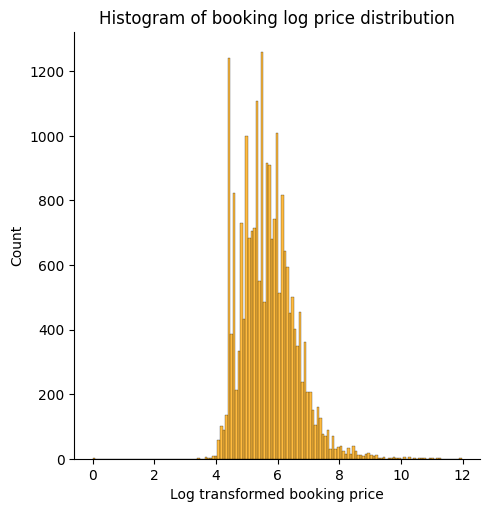

In [109]:
# Price distribution
plt.rcParams["figure.figsize"] = (15,5)
sns.displot(np.log(listing_df['price']+1),
             color='orange')
plt.title('Histogram of booking log price distribution')
plt.xlabel('Log transformed booking price')

### Categorical Variables

In [111]:
listing_df.select_dtypes('object').columns

Index(['listing_url', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'property_type', 'room_type',
       'bathrooms_text', 'amenities', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review',
       'instant_bookable'],
      dtype='object')

In [113]:
listing_df.host_since

0        2010-02-08
1        2010-05-02
2        2010-05-10
3        2010-05-16
4        2010-05-25
            ...    
22323    2020-10-27
22324    2020-10-27
22325    2020-09-08
22326    2015-03-15
22327    2017-04-17
Name: host_since, Length: 22328, dtype: object

In [114]:
listing_df.property_type

0                 Entire apartment
1                 Entire apartment
2                 Entire apartment
3        Private room in apartment
4        Private room in apartment
                   ...            
22323           Room in aparthotel
22324                 Entire house
22325             Entire apartment
22326    Private room in apartment
22327    Private room in apartment
Name: property_type, Length: 22328, dtype: object

In [116]:
property_type_vals = listing_df.property_type.value_counts()

In [117]:
property_type_vals

Entire apartment             7724
Private room in apartment    5138
Room in boutique hotel       1441
Entire serviced apartment    1283
Entire house                  723
                             ... 
Shared room in cabin            1
Yurt                            1
Shared room in cave             1
Entire vacation home            1
Private room in cabin           1
Name: property_type, Length: 96, dtype: int64

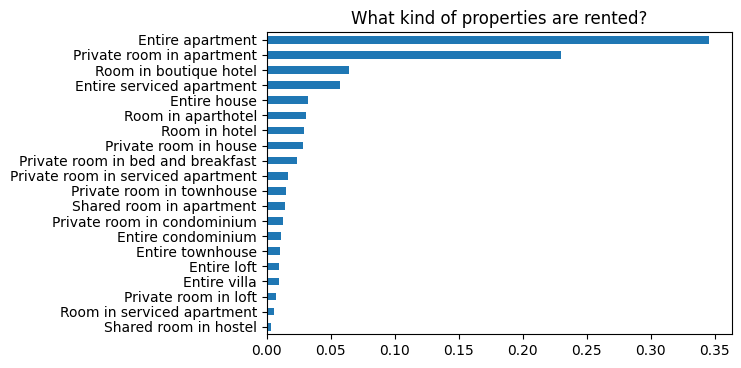

In [130]:
plt.rcParams["figure.figsize"] = (6,4)
(property_type_vals[:20]/listing_df.shape[0]).sort_values().plot(kind="barh");
plt.title("What kind of properties are rented?");

In [35]:
# Columns with no missing values 
set(df.columns[df.isnull().mean() == 0])

{'accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'calendar_last_scraped',
 'has_availability',
 'host_id',
 'host_url',
 'host_verifications',
 'id',
 'instant_bookable',
 'last_scraped',
 'latitude',
 'listing_url',
 'longitude',
 'maximum_maximum_nights',
 'maximum_minimum_nights',
 'maximum_nights',
 'maximum_nights_avg_ntm',
 'minimum_maximum_nights',
 'minimum_minimum_nights',
 'minimum_nights',
 'minimum_nights_avg_ntm',
 'neighbourhood_cleansed',
 'number_of_reviews',
 'number_of_reviews_l30d',
 'number_of_reviews_ltm',
 'picture_url',
 'price',
 'property_type',
 'room_type',
 'scrape_id'}

In [18]:
# Columns that have more than 75% missing
set(df.columns[df.isnull().mean() > 0.75])

{'bathrooms', 'calendar_updated', 'license', 'neighbourhood_group_cleansed'}

In [47]:
df[~df.bathrooms.isnull()]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


In [28]:
# Columns that all missing
set(df.columns[df.isnull().mean() > 0.99])

{'bathrooms', 'calendar_updated', 'license', 'neighbourhood_group_cleansed'}

In [83]:
# Check the correlation of all numeric variables to see which ones are highly correlated with price
corr_variables = listing_df.select_dtypes(include = ['number'])

In [84]:
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams['figure.dpi'] = 100 

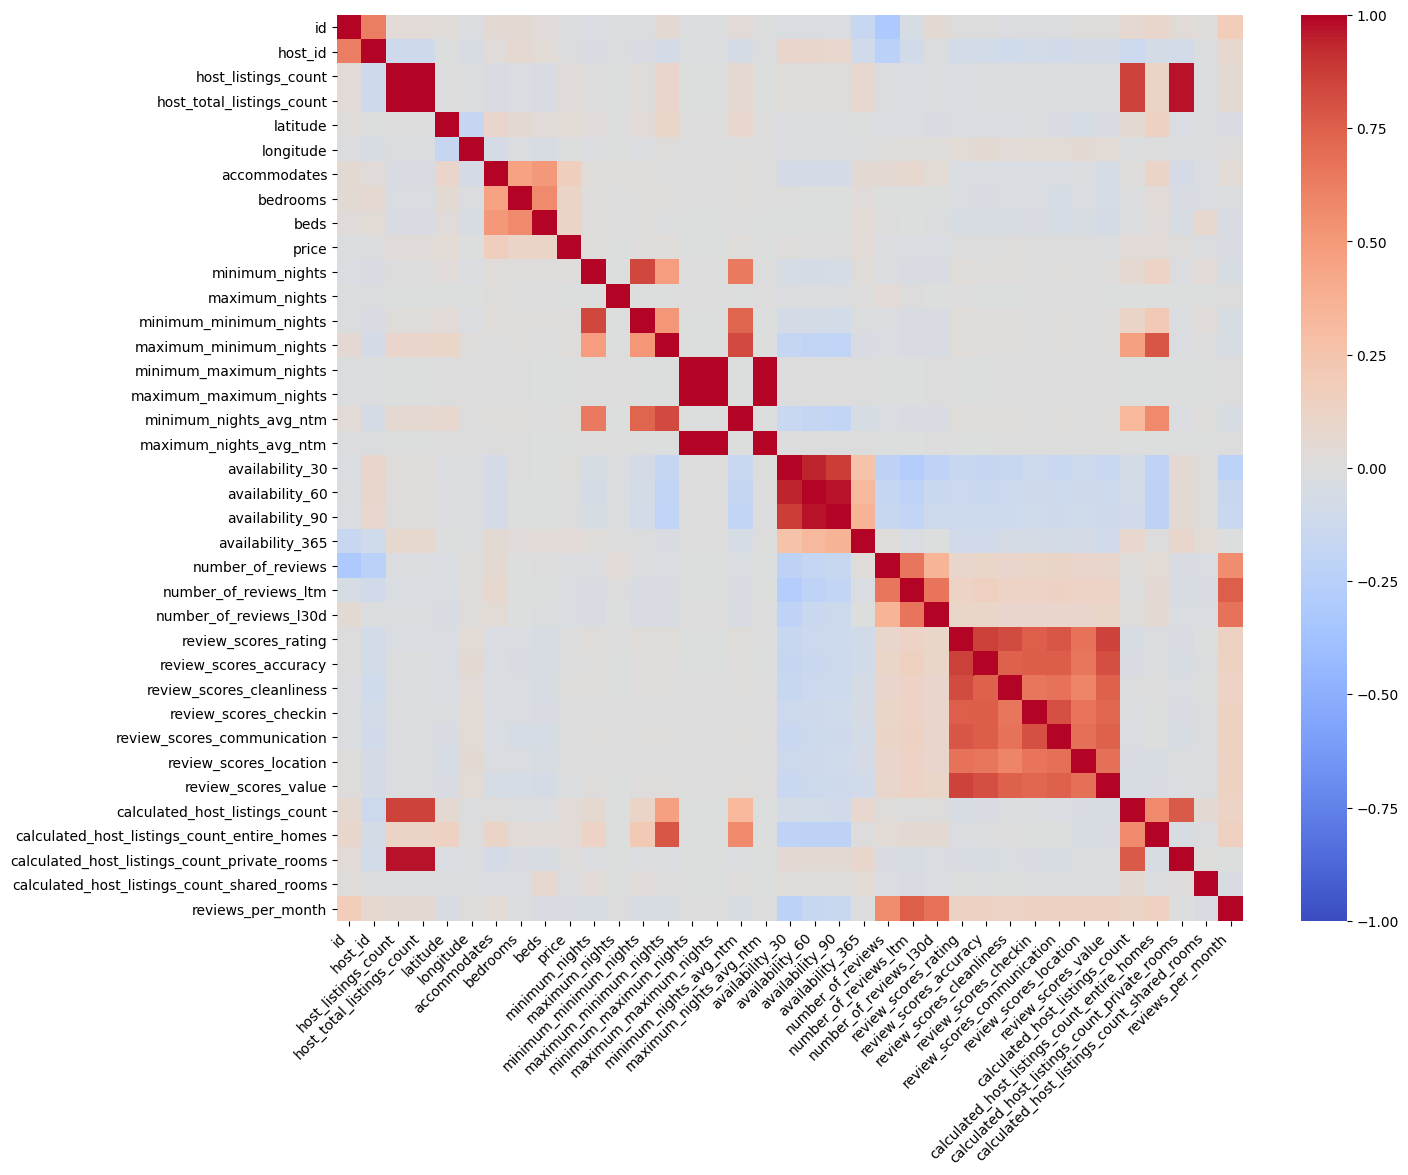

In [85]:
corr = corr_variables.corr()
#matrix = np.tril(corr_variables.corr())
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    cmap = 'coolwarm',
    square=True,
    #annot = True,
    fmt='.1g'
    #mask=matrix
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [64]:
listing_df.scrape_id

0        20201027172200
1        20201027172200
2        20201027172200
3        20201027172200
4        20201027172200
              ...      
22323    20201027172200
22324    20201027172200
22325    20201027172200
22326    20201027172200
22327    20201027172200
Name: scrape_id, Length: 22328, dtype: int64

In [110]:
# Fast solution for large data
#from sklearn.preprocessing import MultiLabelBinarizer

In [162]:
#mlb = MultiLabelBinarizer()

In [163]:
#mlb.fit([df.amenities])

In [120]:
#list(mlb.classes_)

In [108]:
#df_test = pd.DataFrame(mlb.fit([df.amenities]),columns=list(mlb.classes_), index=df.index)

In [121]:
# Create dummy variables from amenities
#df_test = pd.get_dummies(df.amenities.apply(pd.Series).stack()).sum(level=0)

In [122]:
#df_test = pd.get_dummies(df.amenities.apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)

In [164]:
#df_test.head()

In [165]:
#df['test_col'] = df.amenities.str.replace('"', '', regex = True)

In [172]:
df_test = pd.get_dummies(df.set_index('id').amenities.apply(pd.Series).stack()).unstack()

In [174]:
df_test

,"[""43\"" HDTV with standard cable"", ""Room-darkening shades"", ""Dishes and silverware"", ""Heating"", ""Dishwasher"", ""Hair dryer"", ""Paid parking garage off premises"", ""Laptop-friendly workspace"", ""Iron"", ""Wifi \u2013 20 Mbps"", ""Kitchen"", ""Long term stays allowed"", ""Extra pillows and blankets"", ""Coffee maker"", ""Washer"", ""Body soap"", ""Free street parking"", ""Ar\u00e7elik refrigerator"", ""Lockbox"", ""Stainless steel gas stove"", ""Hangers"", ""Private entrance"", ""Luggage dropoff allowed"", ""Cable TV"", ""Essentials"", ""High chair"", ""Laundromat nearby"", ""Bed linens"", ""Hot water"", ""Crib"", ""Cooking basics""]","[""Air conditioning"", ""Heating"", ""Carbon monoxide alarm"", ""First aid kit"", ""Indoor fireplace""]","[""Air conditioning"", ""Kitchen"", ""Heating"", ""Free parking on premises"", ""TV""]","[""Air conditioning"", ""Kitchen"", ""Heating"", ""TV"", ""Washer""]","[""Air conditioning"", ""Kitchen"", ""Shampoo"", ""Breakfast"", ""Washer""]","[""Air conditioning"", ""Kitchen"", ""Shampoo"", ""Heating"", ""TV"", ""Washer""]","[""Air conditioning"", ""Kitchen"", ""TV"", ""Heating"", ""Indoor fireplace"", ""Breakfast"", ""Washer""]","[""Air conditioning"", ""Smoke alarm"", ""Kitchen"", ""Fire extinguisher"", ""Heating"", ""Carbon monoxide alarm"", ""Free parking on premises"", ""TV"", ""Washer""]","[""Air conditioning"", ""Washer"", ""Heating"", ""Kitchen""]","[""Air conditioning"", ""Wifi"", ""Heating""]",...,"[""Wifi"", ""Washer \u2013\u00a0In building"", ""Laptop-friendly workspace"", ""Air conditioning"", ""Dryer \u2013 In building"", ""Smoke alarm"", ""Kitchen"", ""Hangers"", ""Shampoo"", ""Elevator"", ""Fire extinguisher"", ""Heating"", ""Private entrance"", ""Dishwasher"", ""TV"", ""Carbon monoxide alarm"", ""Hair dryer""]","[""Wifi"", ""Washer"", ""Air conditioning"", ""Kitchen""]","[""Wifi"", ""Washer"", ""Heating"", ""Kitchen""]","[""Wifi"", ""Washer"", ""Heating""]","[""Wifi"", ""Washer"", ""Kitchen""]","[""Wifi"", ""Washer"", ""Refrigerator"", ""Kitchen""]","[""Wifi"", ""rebul body soap"", ""Smoke alarm"", ""Heating"", ""rebul shampoo"", ""Lock on bedroom door"", ""Hair dryer"", ""Laptop-friendly workspace"", ""Mini fridge"", ""Air conditioning"", ""First aid kit"", ""TV"", ""Extra pillows and blankets"", ""Paid parking off premises"", ""Hangers"", ""Luggage dropoff allowed"", ""Essentials"", ""Laundromat nearby"", ""Bed linens"", ""Hot water"", ""Fire extinguisher"", ""rebul conditioner""]","[""Wifi""]","[""regal refrigerator"", ""Dishes and silverware"", ""Heating"", ""Shower gel"", ""Hair dryer"", ""Laptop-friendly workspace"", ""Iron"", ""Mini fridge"", ""Kitchen"", ""Shampoo"", ""First aid kit"", ""Long term stays allowed"", ""Extra pillows and blankets"", ""Coffee maker"", ""Freezer"", ""Body soap"", ""Dryer"", ""Free carport on premises \u2013 25 spaces"", ""Hangers"", ""Luggage dropoff allowed"", ""Essentials"", ""Lake access"", ""Laundromat nearby"", ""Central air conditioning"", ""Hot water"", ""Wifi \u2013 5 Mbps"", ""Fire extinguisher"", ""Washer""]",[]
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id,,,,,,,,,,,,,,,,,,,,,
20815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28318,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46075925,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46076686,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [180]:
pd.DataFrame({k: 1 for k in x} for x in df.amenities.values).fillna(0).astype(int)

,[,"""",C,a,b,l,e,,T,V,...,6,4,N,8,U,J,Y,.,j,q
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22323,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
22324,1,1,0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
22325,1,1,0,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
22326,1,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [181]:
one_hot = MultiLabelBinarizer()
a = one_hot.fit_transform(df['amenities'].dropna().str.split(', ')) 

In [182]:
a

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [184]:
df = pd.DataFrame(a, columns=one_hot.classes_ )

In [185]:
df

,""" linens""",""" toiletries""]","""32\"" HDTV""","""33\"" HDTV with standard cable","""39\"" HDTV with standard cable""","""40\"" HDTV with standard cable""","""42\"" HDTV with standard cable""","""42\"" HDTV""","""42\"" TV with standard cable""","""43\"" HDTV with Netflix",...,"[""TV""","[""TV""]","[""Washer""","[""Wifi""","[""Wifi""]","[""regal refrigerator""",[],premium cable,"premium cable""","standard cable"""
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
22326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
